In [1]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import geopandas as gpd
import os
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline
import plotly.express as px
import plotly.graph_objects as go
import missingno as msno
%matplotlib inline

## The goal: find  the best two markets to advertise our product

In this project we're going to analyze freeCodeCamp's 2017 New Coder Survey for an e-learning company. We're looking for the best two markets to advertise online courses. Most of the **courses on offer are on web and mobile development**, but they also cover many other domains, like data science, game development, etc.


* [1. Inital inspection of the dataframe](#initial1)
  * [1.1. Null values](#null11)
  * [1.2. Compressing multiple columns into 1](#compress12)
* [2. Courses](#courses2)
  * [2.1. Amount of courses per person](#coursespp21)
  * [2.2. Most popular courses](#popularcourses22)
  * [2.3. Share of people interested in Web or Mobile](#share23)
  * [2.4. Remove null value rows](#remove24) 
* [3. Participants by country](#country3)
* [4. Monthly budget](#monthly4)
  * [4.1. Calculating monthly budget](#calculate41)
  * [4.2. Analyzing monthly values](#analyze42)
  * [4.3. Managing extreme values](#manage43)
* [5. Age](#age5)
  * [5.1. Age affecting monthly budget](#age51)
* [6. Other factors](#other6)
* [7. Conclusions](#conclusions7)



<a id='counastry3'></a>

<a id='initial1'></a>

# 1. Inital inspection of the dataframe

In [2]:
data = pd.read_csv('2017-fCC-New-Coders-Survey-Data.csv', low_memory=False)
data.head()

,Age,AttendedBootcamp,BootcampFinish,BootcampLoanYesNo,BootcampName,BootcampRecommend,ChildrenNumber,CityPopulation,CodeEventConferences,CodeEventDjangoGirls,...,YouTubeFCC,YouTubeFunFunFunction,YouTubeGoogleDev,YouTubeLearnCode,YouTubeLevelUpTuts,YouTubeMIT,YouTubeMozillaHacks,YouTubeOther,YouTubeSimplilearn,YouTubeTheNewBoston
0,27.0,0.0,NaN,NaN,NaN,NaN,NaN,more than 1 million,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,34.0,0.0,NaN,NaN,NaN,NaN,NaN,"less than 100,000",NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,21.0,0.0,NaN,NaN,NaN,NaN,NaN,more than 1 million,NaN,NaN,...,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN
3,26.0,0.0,NaN,NaN,NaN,NaN,NaN,"between 100,000 and 1 million",NaN,NaN,...,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,20.0,0.0,NaN,NaN,NaN,NaN,NaN,"between 100,000 and 1 million",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18175 entries, 0 to 18174
Columns: 136 entries, Age to YouTubeTheNewBoston
dtypes: float64(105), object(31)
memory usage: 18.9+ MB


<a id='null11'></a>

# 1.1. Null values

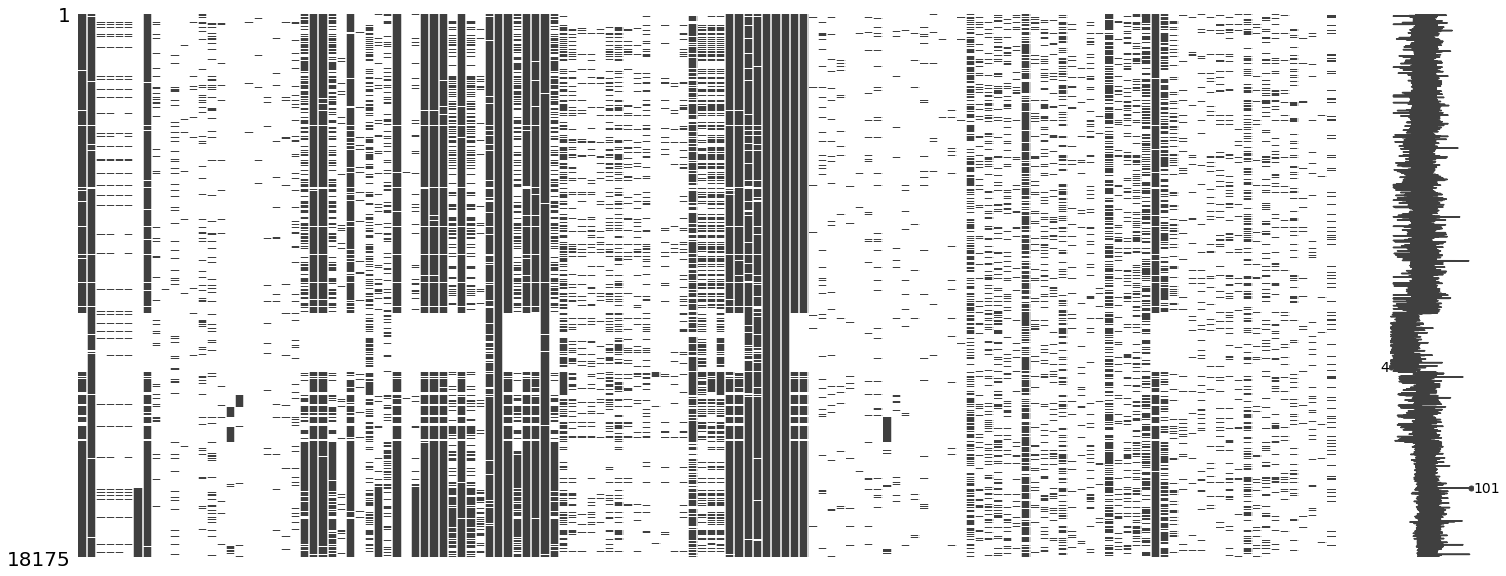

In [4]:
msno.matrix(data)
plt.show()

Using the missingno library we can have a quick look at the null values(white) of the dataframe. It is obvious that majority of the columns in the dataframe don't contain any values. We can also observe a group of empty rows right in the middle of the dataframe. Now lets have a closer look at the column names:

In [5]:
data.columns.tolist()

['Age',
 'AttendedBootcamp',
 'BootcampFinish',
 'BootcampLoanYesNo',
 'BootcampName',
 'BootcampRecommend',
 'ChildrenNumber',
 'CityPopulation',
 'CodeEventConferences',
 'CodeEventDjangoGirls',
 'CodeEventFCC',
 'CodeEventGameJam',
 'CodeEventGirlDev',
 'CodeEventHackathons',
 'CodeEventMeetup',
 'CodeEventNodeSchool',
 'CodeEventNone',
 'CodeEventOther',
 'CodeEventRailsBridge',
 'CodeEventRailsGirls',
 'CodeEventStartUpWknd',
 'CodeEventWkdBootcamps',
 'CodeEventWomenCode',
 'CodeEventWorkshops',
 'CommuteTime',
 'CountryCitizen',
 'CountryLive',
 'EmploymentField',
 'EmploymentFieldOther',
 'EmploymentStatus',
 'EmploymentStatusOther',
 'ExpectedEarning',
 'FinanciallySupporting',
 'FirstDevJob',
 'Gender',
 'GenderOther',
 'HasChildren',
 'HasDebt',
 'HasFinancialDependents',
 'HasHighSpdInternet',
 'HasHomeMortgage',
 'HasServedInMilitary',
 'HasStudentDebt',
 'HomeMortgageOwe',
 'HoursLearning',
 'ID.x',
 'ID.y',
 'Income',
 'IsEthnicMinority',
 'IsReceiveDisabilitiesBenefits'

We can notice groups of columns that start with service name or type and then specific channel/ name of that service. Lets check what is the share of null values in these column groups?

In [6]:
keywords = ['CodeEvent', 'Podcast', 'YouTube', 'Resource', 'JobInterest']
avg_nulls_in_column = {}
for word in keywords:
    avg_nulls_in_column[word] = data.loc[:,[word in i for i in data.columns]].isnull().sum().sort_values(ascending=False).mean() / len(data)
avg_nulls_in_column

{'CodeEvent': 0.9511691884456671,
 'Podcast': 0.964482563314184,
 'YouTube': 0.8917096852496156,
 'Resource': 0.7508803301237964,
 'JobInterest': 0.8892265368744049}

It is quite obvious that the mentioned columns contain mostly null values.

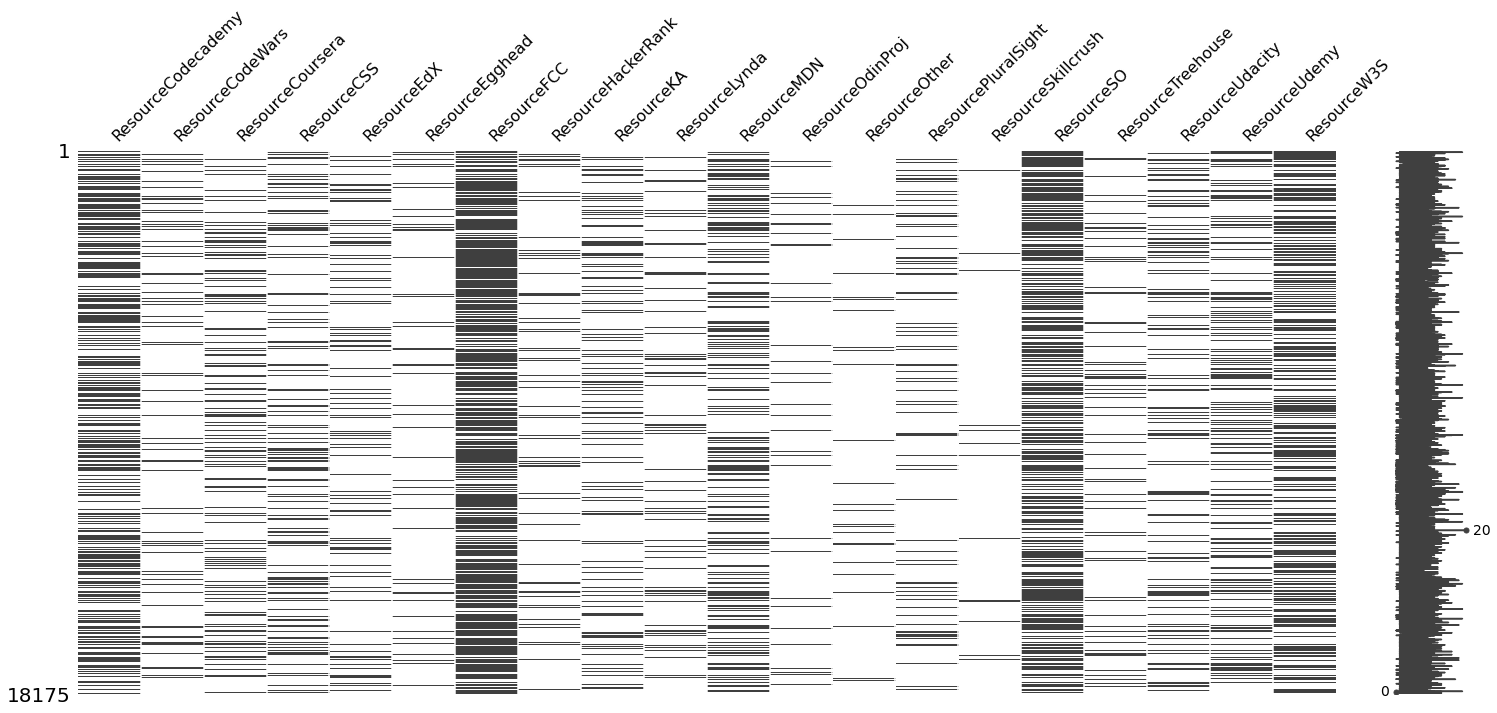

In [7]:
msno.matrix(data.loc[:,['Resource' in i for i in data.columns]])
plt.show()

<a id='compress12'></a>

# 1.2. Compressing multiple columns into one column per service

Instead of removing all of the service type columns we'll resort to compressing their content. For all the columns representing an individual YouTube channel per column, we'll create one column and compress all values for YouTube columns into that 1 column. We'll apply the same method for columns starting with: 'CodeEvent', 'Podcast', 'YouTube', 'Resource', 'JobInterest'


In [8]:
keywords_to_pack = ['CodeEvent', 'Podcast', 'YouTube', 'Resource', 'JobInterest']
df = data
for keyword in keywords_to_pack:
    cols_names = [col for col in df.columns if keyword in col]
    df[keyword] = df[cols_names].any(axis=1)
    df = df.drop(columns=cols_names)
df = df.rename(columns={'Resource':'online_learning'})

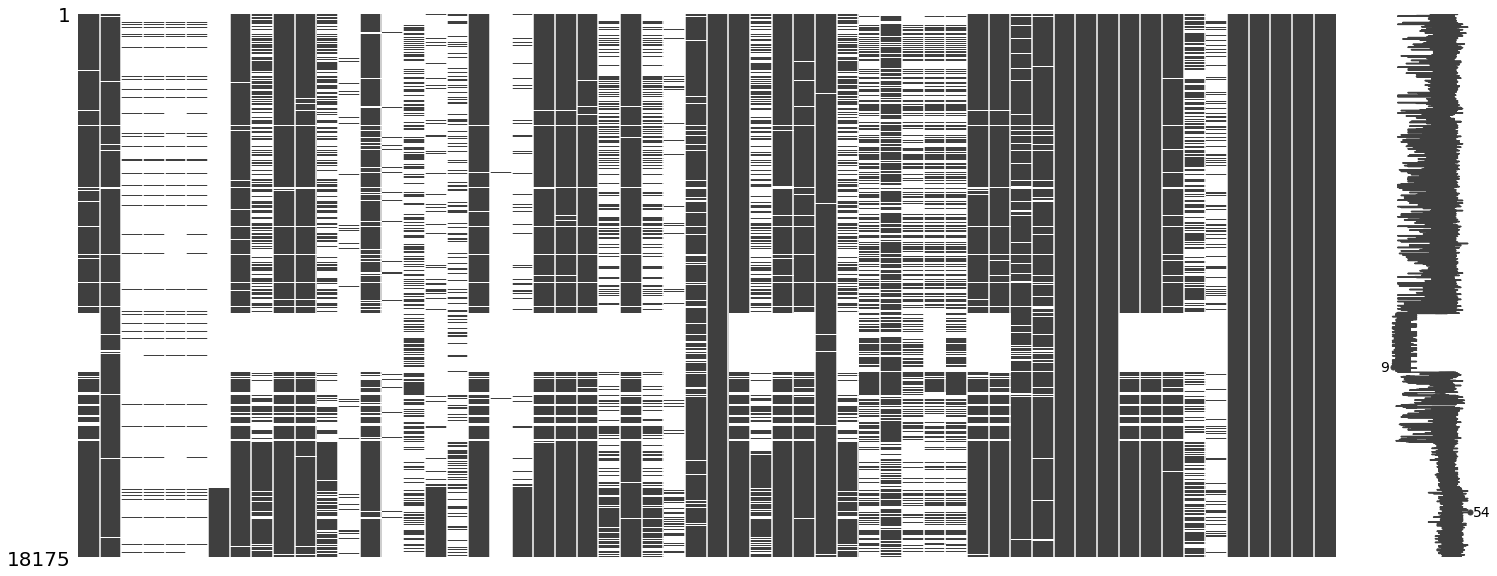

In [9]:
msno.matrix(df)
plt.show()

lets remove the group of rows with null values:

In [10]:
df = df.dropna(thresh=20, axis=0)

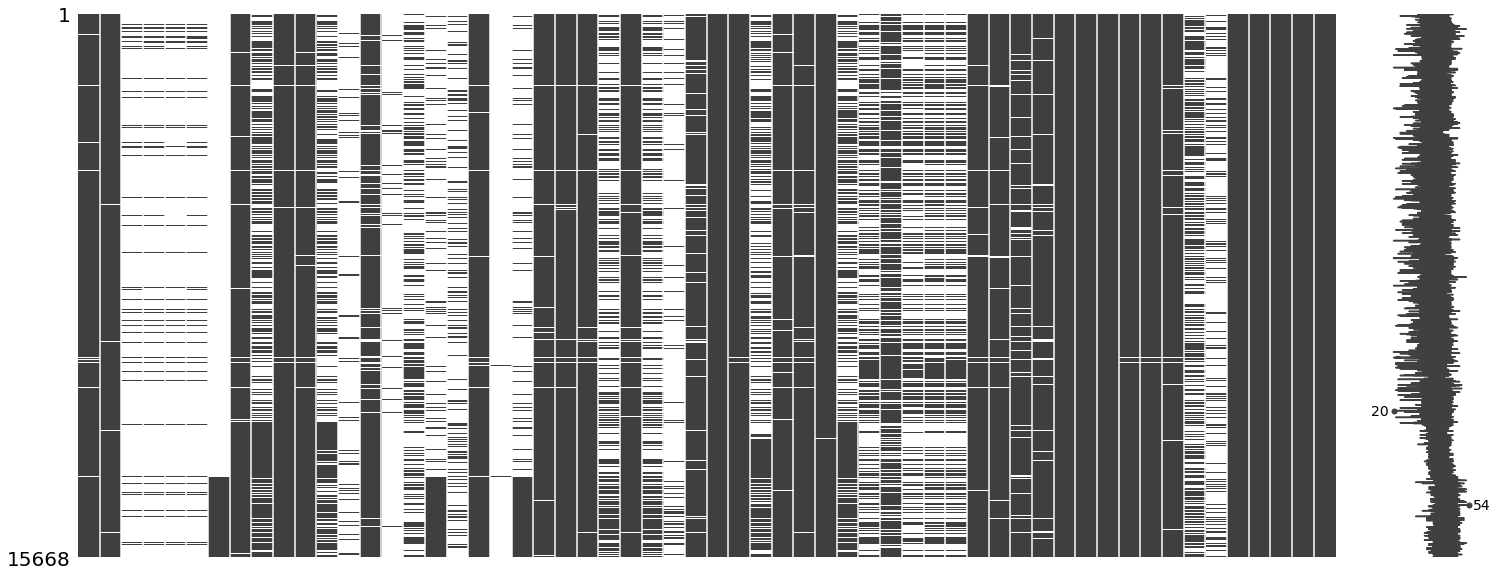

In [11]:
msno.matrix(df)
plt.show()

In [12]:
df.describe(include='all')

,Age,AttendedBootcamp,BootcampFinish,BootcampLoanYesNo,BootcampName,BootcampRecommend,ChildrenNumber,CityPopulation,CommuteTime,CountryCitizen,...,Part2EndTime,Part2StartTime,SchoolDegree,SchoolMajor,StudentDebtOwe,CodeEvent,Podcast,YouTube,online_learning,JobInterest
count,15361.000000,15472.000000,976.000000,985.000000,874,979.000000,2314.000000,15351,9246,15380,...,15611,15611,15365,8726,3362.000000,15668,15668,15668,15668,15668
unique,NaN,NaN,NaN,NaN,134,NaN,NaN,3,6,181,...,15527,15524,10,472,NaN,2,2,2,2,2
top,NaN,NaN,NaN,NaN,General Assembly,NaN,NaN,more than 1 million,15 to 29 minutes,United States of America,...,2017-03-09 22:11:47,2017-04-06 22:13:21,bachelor's degree,Computer Science,NaN,False,False,True,True,False
freq,NaN,NaN,NaN,NaN,56,NaN,NaN,6532,2478,5479,...,2,2,5849,1344,NaN,8215,9828,11346,15558,8663
mean,27.695463,0.064504,0.699795,0.304569,NaN,0.821246,1.832325,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,31602.625521,NaN,NaN,NaN,NaN,NaN
std,8.556923,0.245656,0.458582,0.460458,NaN,0.383342,0.972813,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,39383.187732,NaN,NaN,NaN,NaN,NaN
min,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,1.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,100.000000,NaN,NaN,NaN,NaN,NaN
25%,22.000000,0.000000,0.000000,0.000000,NaN,1.000000,1.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,9536.500000,NaN,NaN,NaN,NaN,NaN
50%,26.000000,0.000000,1.000000,0.000000,NaN,1.000000,2.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,20000.000000,NaN,NaN,NaN,NaN,NaN
75%,32.000000,0.000000,1.000000,1.000000,NaN,1.000000,2.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,40000.000000,NaN,NaN,NaN,NaN,NaN


<a id='courses2'></a>

# 2. Courses

In this section we'll analyze data about courses. How many courses are of interest to people? What topic?

<a id='coursespp21'></a>

# 2.1. How many courses are of interest for an average person?

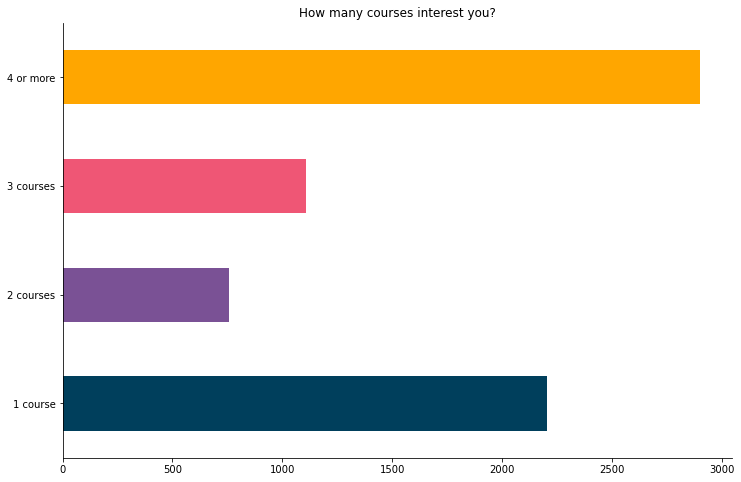

In [13]:
def how_many(x):
    if len(x) == 1:
        return '1 course'
    elif len(x) == 2:
        return '2 courses' 
    elif (len(x) >= 3) & (len(x) < 4):
        return '3 courses'
    else :
        return '4 or more'
colors = ['#003f5c','#7a5195','#ef5675','#ffa600']

roles = pd.DataFrame(df["JobRoleInterest"]).dropna(subset=["JobRoleInterest"]).copy()
roles["JobRoleInterest"] = roles["JobRoleInterest"].str.split(',')
roles["SeveralRoles"] = roles["JobRoleInterest"].apply(how_many)
roles["SeveralRoles"].value_counts().sort_index()
ax = plt.subplot()
roles["SeveralRoles"].value_counts().sort_index().plot.barh(color=colors,  figsize =(12, 8))
plt.title("How many courses interest you?")
for location in [ 'right', 'top']:
            ax.spines[location].set_visible(False)
plt.show()

## 2.2. The most popular courses

<a id='popularcourses22'></a>

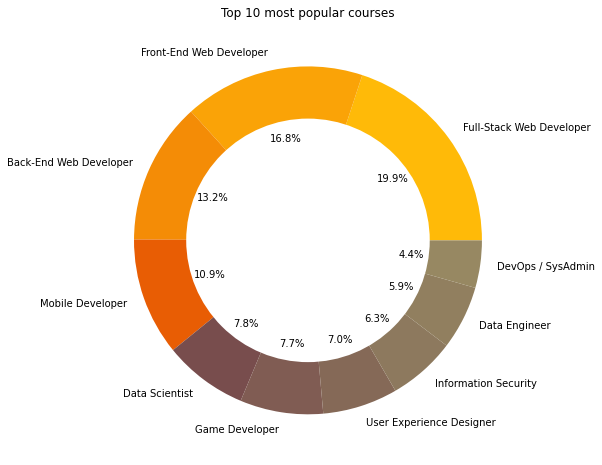

In [14]:
colors = ["#978862","#917f5f","#8d795e","#856957","#805c53","#784d4d","#e85d04","#f48c06","#faa307","#ffba08"]
colors = list(reversed(colors))
df['JobRoleInterest'] = df['JobRoleInterest'].str.replace(pat=r",\s+", repl=',', regex=True)
df['JobRoleInterest'] = df['JobRoleInterest'].str.lstrip()
df[df['JobRoleInterest'] == 'nan'] = None

plt.subplots(figsize =(12, 8))
df['JobRoleInterest'].str.split(',', expand=True).stack().value_counts(dropna=True)[:10].plot.pie(colors=colors,autopct='%1.1f%%')
plt.ylabel("")
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Top 10 most popular courses')
plt.show()

In [15]:
# colors = ['#00876c', '#379469', '#58a066', '#78ab63', '#98b561', '#b8bf62', '#dac767', '#deb256', 
#           '#e09d4b', '#e18745', '#e06f45', '#dc574a', '#d43d51']
# ax = plt.subplot()
# df['JobRoleInterest'].str.split(',', expand=True).stack().value_counts(dropna=True)[:10].sort_values(ascending=True).plot.barh(color=colors, figsize =(12, 8))
# plt.ylabel("")

# for location in [ 'right', 'top']:
#             ax.spines[location].set_visible(False)
# plt.show()

# 2.3. Share of people interested in Web or Mobile

<a id='share23'></a>

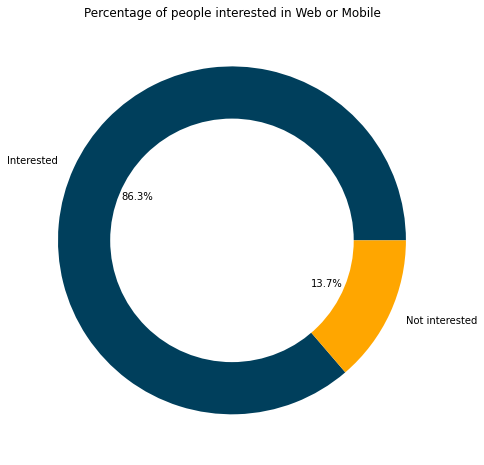

In [16]:
plt.subplots(figsize =(12, 8))
df["JobRoleInterest"].str.contains('Web Developer|Mobile Developer').value_counts(normalize=True).plot.pie(labels=('Interested','Not interested'),
colors=["#003f5c", "#ffa600"] ,autopct='%1.1f%%')
plt.title('Percentage of people interested in Web or Mobile')
plt.ylabel(ylabel=None)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.show()

Lets not forget that survey participant were allowed to choose more than 1 course. The share of people who are interested in companies main courses (Web or Mobile) works in our favor.

<a id='remove24'></a>

# 2.4. Remove rows with null values in 'JobRoleInterest'

In [17]:
df['CountryLive'].value_counts(normalize=True)[:5]

United States of America    0.377657
India                       0.091235
United Kingdom              0.049367
Canada                      0.040172
Brazil                      0.023738
Name: CountryLive, dtype: float64

In [19]:
df_clean = df[df["JobRoleInterest"].notnull()]

<a id='country3'></a>

# 3. Participants by country 

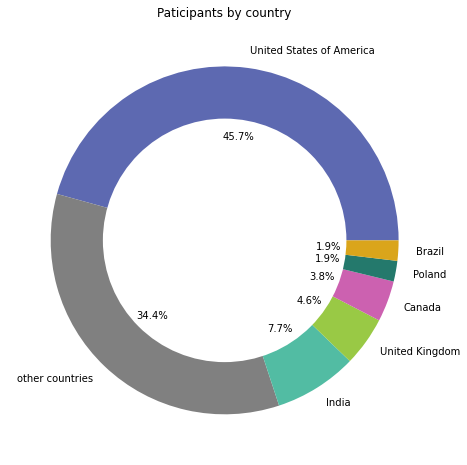

In [20]:
# country_share = df['CountryLive'].value_counts(normalize=True)
colors = ['#5D69B1','grey','#52BCA3','#99C945','#CC61B0','#24796C','#DAA51B','#2F8AC4','#764E9F','#ED645A','#CC3A8E','#A5AA99']

pie_frame = pd.DataFrame()
pie_frame['Country'] = df_clean['CountryLive']
others =  df_clean['CountryLive'].value_counts()[6:].index
pie_frame.loc[pie_frame['Country'].isin(others),'Country'] = 'other countries'
plt.subplots(figsize =(12, 8))
pie_frame["Country"].value_counts().plot.pie(colors=colors, autopct='%1.1f%%')
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.ylabel("")
plt.title("Paticipants by country")
plt.show()


Our task is most likely 50% finished. Given the fact that almost half of survey participants reside in the US, our task is not about finding the 2 markets, but looking for the second one. This is almost certain, unless the participants from US have extremely low spending capabilities compared to the next few countries (which is very unlikely). The following three countries all share the same language. We'll narrow down our dataframe to US and  the following 3 countries: India, UK and Canada.

In [21]:
df_clean['MonthsProgramming'].dropna()

1         6.0
2         5.0
3         5.0
4        24.0
6        12.0
         ... 
18160     3.0
18161     6.0
18162    84.0
18171     1.0
18174    10.0
Name: MonthsProgramming, Length: 6632, dtype: float64

In [22]:
countries = df_clean['CountryLive'].value_counts(normalize=True)[:4].index.tolist()
top4 = df_clean[df_clean['CountryLive'].isin(countries)].copy()

<a id='monthly4'></a>

# 4. Monthly budget

We'll start analyzing our participants spending potential:
* calculate their monthly spending
* calculate and analyze mean, median and mode values

<a id='calculate41'></a>

# 4.1. Calculating monthly spending

Using the columns 'MonthsProgramming' and 'MoneyForLearning' we'll deduct the monthly budget for each participant. 
* To avoid the issue of dividing by 0, we'll replace every 0 value in 'MonthsProgramming' with 1
* Next we'll divide 'MoneyForLearning' by 'MonthsProgramming'
* The result is the amount of money spent per month, we'll store that value in 'Money_month' column

In [23]:
top4.loc[top4['MonthsProgramming'] == 0, 'MonthsProgramming'] = 1
top4['MoneyForLearning'] = top4['MoneyForLearning'].dropna()
top4.loc['MonthsProgramming'] = top4['MonthsProgramming'].dropna()
top4['Money_month'] = top4['MoneyForLearning'] / top4['MonthsProgramming']

<a id='analyze42'></a>

# 4.2. Analyzing monthly spending

In [24]:
top4.groupby('CountryLive')['Money_month'].mean()

CountryLive
Canada                      113.510961
India                       135.100982
United Kingdom               45.534443
United States of America    227.997996
Name: Money_month, dtype: float64

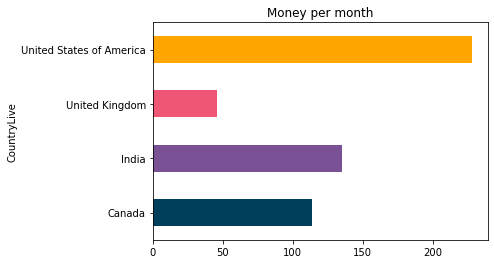

In [25]:
colors = ['#003f5c','#7a5195', '#ef5675', '#ffa600']
top4.groupby('CountryLive')['Money_month'].mean().plot.barh(color=colors)
plt.title('Money per month')
plt.show()

Abnormally high mean value for India (higher than UK or Canada) points to potential presence of extreme values for India.

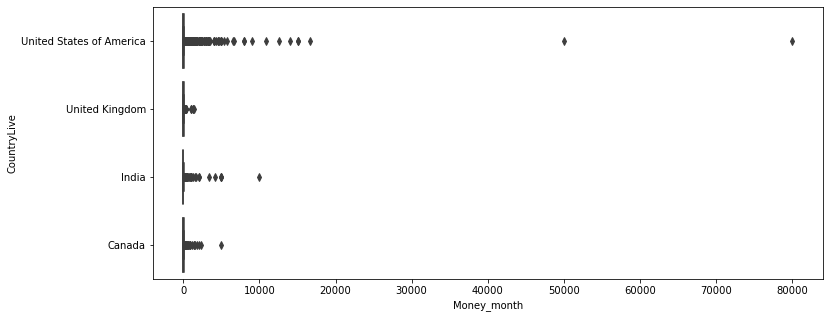

In [26]:
plt.subplots(figsize = (12, 5))
sns.boxplot(x = 'Money_month', y = 'CountryLive',
             data = top4, )

plt.show()

Above we can clearly see extreme values of monthly spending. We should take into consideration those values with further works:
* avoid using mean for monthly spending, try using median or mode instead
* remove the abnormally high values 

<a id='manage43'></a>

# 4.3. Managing extreme values

We'll remove any entries with monthly spending higher than 5000, we'll also remove participants younger than 15 years.

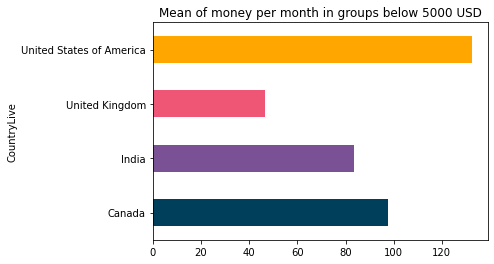

In [27]:
normal = top4[(top4['Money_month']<5000) & (top4['Age']>15)].copy()
colors = ['#003f5c','#7a5195', '#ef5675', '#ffa600']
normal.groupby('CountryLive')['Money_month'].mean().plot.barh(color=colors)
plt.title('Mean of money per month in groups below 5000 USD')
plt.show()



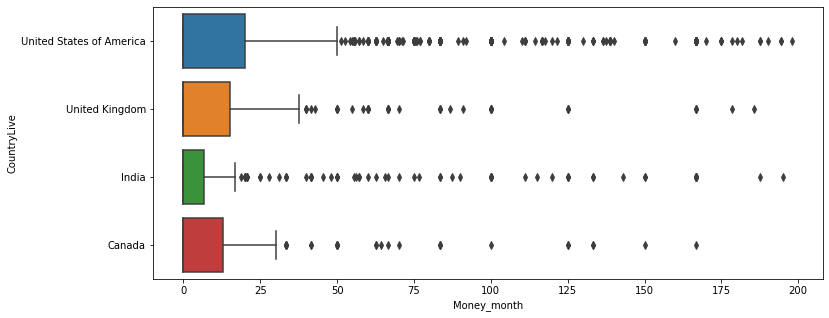

In [30]:
plt.subplots(figsize = (12, 5))
sns.boxplot(x = 'Money_month', y = 'CountryLive',
             data = top4[top4['Money_month']<200])

plt.show()

In [31]:
top4.groupby('CountryLive')['Money_month'].median()

CountryLive
Canada                      0.000000
India                       0.000000
United Kingdom              0.000000
United States of America    3.333333
Name: Money_month, dtype: float64

Although the mean values for each country are above 100 USD (except UK). The median values show a different picture:
* majority of participants in UK, Canada and India don't spend any money for their education 
* US once again proves to be the market leader and the most attractive market with a median of 3.33

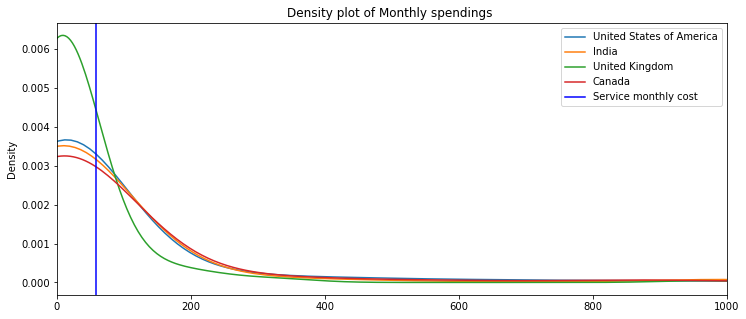

In [32]:
countries = normal['CountryLive'].value_counts(normalize=True).index.tolist()
plt.subplots(figsize = (12, 5))
for country in countries:
    normal[normal['CountryLive']==country]['Money_month'].plot.kde(label=country)
    
    plt.xlim(0,1000)

plt.title('Density plot of Monthly spendings ')
plt.axvline(59, color='b', label='Service monthly cost')
plt.legend()  
plt.show()

UK looks very good on the above plot, but lets remember: Kernel density plot is 'smoothed out'. Lets make sure that we're correct:

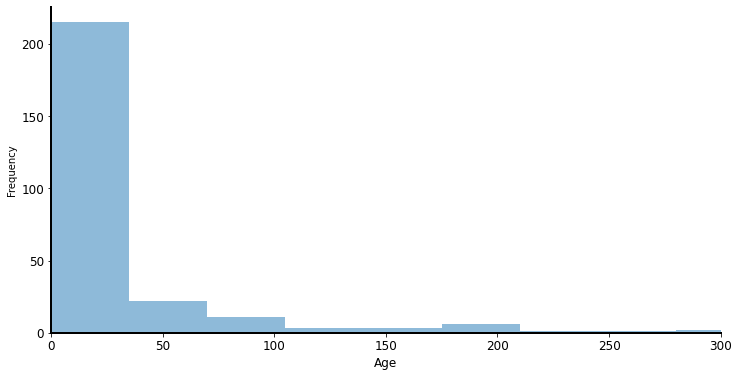

In [33]:
plt.subplots(figsize = (12, 6))
ax = plt.subplot()
normal[normal['CountryLive']=='United Kingdom']['Money_month'].plot.hist(bins=40,  alpha=0.5)
for location in [ 'right', 'top']:
        ax.spines[location].set_visible(False)
for location in [ 'left', 'bottom']:
        ax.spines[location].set_linewidth(2)
        ax.tick_params(labelsize=12)
ax.set_xlabel('Age',size=12)
plt.xlim(0,300)
plt.show()

We have gained two solid reasons to eliminate UK from our list of candidates for the second market:
* lowest mean value for monthly spendings on education, even after removing the outliers
* histogram clearly presents the fact, that majority of participants from UK have a monthly budget below the 50 $ level


<a id='age5'></a>

# 5. Age data

In [34]:
normal['Age'].value_counts(bins=10).sort_index()

(15.944, 21.5]     813
(21.5, 27.0]      1211
(27.0, 32.5]       753
(32.5, 38.0]       512
(38.0, 43.5]       203
(43.5, 49.0]       139
(49.0, 54.5]        64
(54.5, 60.0]        43
(60.0, 65.5]        13
(65.5, 71.0]         5
Name: Age, dtype: int64

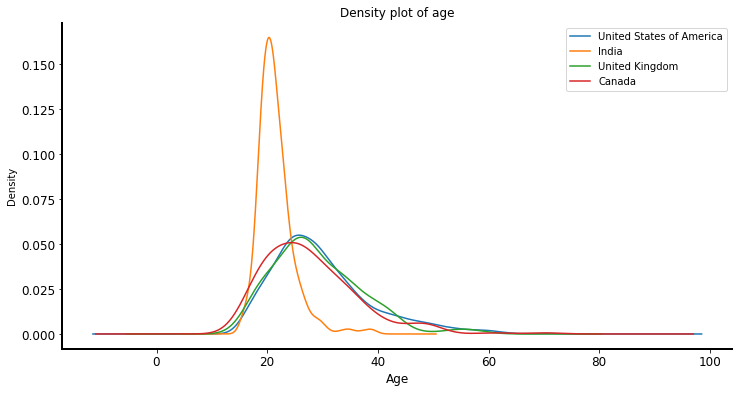

In [35]:
countries = top4['CountryLive'].value_counts(normalize=True).index.tolist()
plt.subplots(figsize = (12, 6))
ax = plt.subplot()
for country in countries:
    normal[normal['CountryLive']==country]['Age'].plot.kde(label=country)
    plt.title("Density plot of age")
for location in [ 'right', 'top']:
        ax.spines[location].set_visible(False)
for location in [ 'left', 'bottom']:
        ax.spines[location].set_linewidth(2)
        ax.tick_params(labelsize=12)
ax.set_xlabel('Age',size=12)
plt.legend()    
plt.show()

Kernel density plot of Age values, uncovers a difference of valu distribution between India and other countries:
* minimal difference in age distribution among US, UK and Canada, fairly even value distribution
* clearly visible high concentration of age values for India only in one age group
* average age of Indian participants is significantly lower than others

In [36]:
for country in countries:
    print('Average age for',country,'is',round(normal[normal['CountryLive']==country]['Age'].mean(),2))

Average age for United States of America is 29.73
Average age for India is 21.51
Average age for United Kingdom is 28.94
Average age for Canada is 27.79


In [37]:
avg_age_df_nn = {}
for word in countries:
    avg_age_df_nn[word] = normal[normal['CountryLive']==word]["JobRoleInterest"].str.contains('Web Developer|Mobile Developer').value_counts(normalize=True)
mobile_frame = pd.DataFrame.from_dict(avg_age_df_nn, orient='index')
mobile_frame
#     pd.concat([pd.Series(avg_age_df_nn), pd.Series(avg_age_df), pd.Series(avg_age_df_nn) - pd.Series(avg_age_df)],
#           axis=1, keys=['dropped_nulls', 'with_nulls', 'difference'])

,True,False
United States of America,0.864461,0.135539
India,0.848889,0.151111
United Kingdom,0.889299,0.110701
Canada,0.852679,0.147321


<a id='age51'></a>

# 5.1. How age affects monthly spending budget

Majority of values in 'Money_month' are zeros. We'll remove those values for purpose of plotting the remaining values on median and mode charts.

In [38]:
normal_no0 = normal[normal['Money_month']!=0][['Money_month', 'Age']]

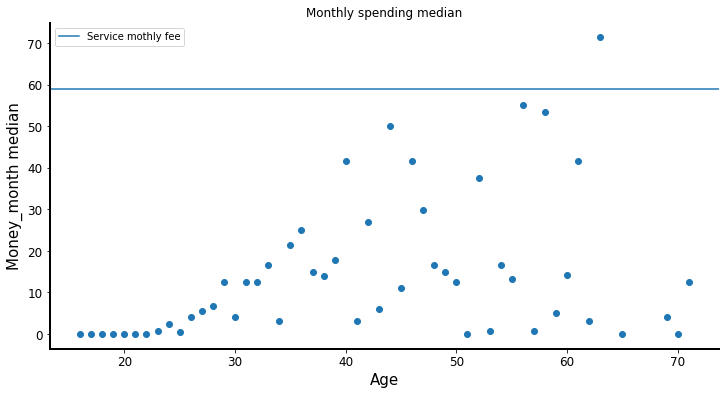

In [79]:
ages_median = normal.groupby('Age')['Money_month'].median()

plt.subplots(figsize = (12, 6))
ax = plt.subplot()
plt.scatter(ages_median.index.tolist(), ages_median)
plt.axhline(59, label='Service mothly fee')
plt.title('Monthly spending median')
ax.set_xlabel('Age',size=15)
ax.set_ylabel('Money_month median',size=15)
for location in [ 'right', 'top']:
        ax.spines[location].set_visible(False)
for location in [ 'left', 'bottom']:
        ax.spines[location].set_linewidth(2)
        ax.tick_params(labelsize=12)
plt.legend()
plt.show()      

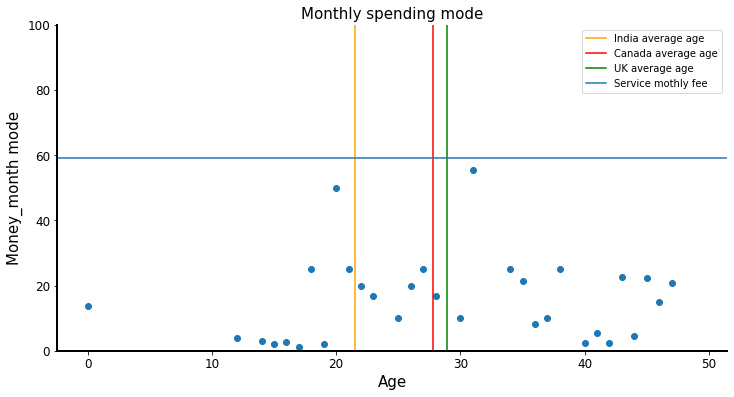

In [76]:
canada_age = normal[normal['CountryLive']=='Canada']['Age'].mean()
india_age = normal[normal['CountryLive']=='India']['Age'].mean()
uk_age = normal[normal['CountryLive']=='United Kingdom']['Age'].mean()

list_of_ages = normal_no0['Age'].value_counts().sort_index().index.tolist()

# loop them, check value_counts for every age, sort the value_counts and extract the 1st value:
mode_of_age = []
for age in list_of_ages:
    mode_of_age.append(normal_no0[normal_no0['Age'] == age].Money_month.value_counts().index.tolist()[0])
# create a dataframe out of these two lists   
age_mode_df = pd.DataFrame(list(zip(list_of_ages, mode_of_age)), columns =['Age', 'Mode'])

plt.subplots(figsize = (12, 6))
ax = plt.subplot()
plt.scatter(age_mode_df['Age'], age_mode_df['Mode'])
for location in [ 'right', 'top']:
        ax.spines[location].set_visible(False)
for location in [ 'left', 'bottom']:
        ax.spines[location].set_linewidth(2)
        ax.tick_params(labelsize=12)
ax.set_xlabel('Age',size=15)
ax.set_ylabel('Money_month mode',size=15)
plt.axvline(india_age, color='orange', label='India average age')
plt.axvline(canada_age, color='red', label='Canada average age')
plt.axvline(uk_age, color='green', label='UK average age')
plt.axhline(59, label='Service mothly fee')
plt.legend()
plt.ylim(0,100)
plt.title('Monthly spending mode', size=15)

plt.show()    

The monthly spending median and mode point to similar conclusions.
* monthly spending is slowly increasing throughout the whole of carreer
* the mode of monthly spending is passing the 50 $ mark in 30s

<a id='other6'></a>

# 6. Other factors

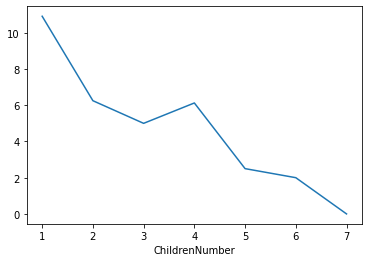

In [46]:
normal.groupby('ChildrenNumber')['Money_month'].median().plot.line()
plt.show()

In [47]:
# how participation in various online learning platforms affect monthly spending median 
keywords = ['CodeEvent', 'Podcast', 'YouTube', 'online_learning', 'AttendedBootcamp']
df_list = []
bins_data = pd.cut(top4['Age'], [0,16, 21, 27, 35, 45, 55, 71])
overall = top4.groupby(bins_data)['Money_month'].agg('median')
df_list.append(overall)

for colname in keywords:
    bins_data = pd.cut(top4[top4[colname]==True]['Age'], [0,16, 21, 27, 35, 45, 55, 71])
    df_list.append(top4[top4[colname]==True].groupby(bins_data)['Money_month'].agg('median'))

pd.concat(df_list, axis=1, keys=['Overall']+keywords)

,Overall,CodeEvent,Podcast,YouTube,online_learning,AttendedBootcamp
Age,,,,,,
"(0, 16]",0.000000,0.000000,0.000000,0.000000,0.000000,500.000000
"(16, 21]",0.000000,0.000000,0.000000,0.000000,0.000000,666.666667
"(21, 27]",1.562500,5.000000,5.000000,3.333333,1.581250,583.333333
"(27, 35]",11.764706,20.000000,16.666667,14.285714,11.764706,500.000000
"(35, 45]",16.666667,25.000000,16.666667,20.000000,16.666667,500.000000
"(45, 55]",16.666667,33.333333,18.750000,20.000000,16.666667,833.333333
"(55, 71]",8.452381,18.125000,12.500000,9.285714,8.571429,83.333333


In [48]:
top4.groupby('CountryLive')['CodeEvent'].value_counts()

CountryLive               CodeEvent
Canada                    False         133
                          True          127
India                     True          295
                          False         233
United Kingdom            False         200
                          True          115
United States of America  False        1632
                          True         1493
Name: CodeEvent, dtype: int64

In [49]:
top4.groupby('CountryLive')['ChildrenNumber'].mean()

CountryLive
Canada                      1.896552
India                       1.333333
United Kingdom              1.816327
United States of America    1.908612
Name: ChildrenNumber, dtype: float64

In [50]:
top4.groupby('CountryLive')['CityPopulation'].value_counts()

CountryLive               CityPopulation               
Canada                    more than 1 million               135
                          between 100,000 and 1 million      89
                          less than 100,000                  33
India                     more than 1 million               304
                          between 100,000 and 1 million     165
                          less than 100,000                  50
United Kingdom            between 100,000 and 1 million     111
                          more than 1 million               111
                          less than 100,000                  86
United States of America  between 100,000 and 1 million    1207
                          more than 1 million               941
                          less than 100,000                 940
Name: CityPopulation, dtype: int64

In [51]:
top4.groupby('CountryLive')['Income'].median().sort_values()

CountryLive
United Kingdom              27170.0
Canada                      28000.0
India                       36000.0
United States of America    40000.0
Name: Income, dtype: float64

In [52]:
top4.groupby('CityPopulation')['Money_month'].median().sort_values()

CityPopulation
less than 100,000                0.166667
between 100,000 and 1 million    2.500000
more than 1 million              2.500000
Name: Money_month, dtype: float64

In [53]:
data.columns.values.tolist()
corelate = normal.corr()
corelate['Money_month'] = abs(corelate['Money_month'])

#lets see which ones are the most important:
corelate['Money_month'].sort_values(ascending=False)[:30]

Money_month                      1.000000
MoneyForLearning                 0.719284
AttendedBootcamp                 0.442376
HoursLearning                    0.160194
Age                              0.102148
FinanciallySupporting            0.079800
BootcampLoanYesNo                0.075416
Income                           0.070077
HasDebt                          0.065312
MonthsProgramming                0.061501
BootcampFinish                   0.056180
ChildrenNumber                   0.051874
HasFinancialDependents           0.051230
BootcampRecommend                0.048669
HasHighSpdInternet               0.047212
HasChildren                      0.042939
HomeMortgageOwe                  0.039039
JobRelocateYesNo                 0.036036
StudentDebtOwe                   0.035130
ExpectedEarning                  0.025742
HasStudentDebt                   0.025702
HasHomeMortgage                  0.024730
IsEthnicMinority                 0.023827
HasServedInMilitary              0

<a id='conclusions7'></a>

# 7. Conclusions

* United States of America should be our primary market and object of main campaign
* United Kingdom should not be considered, there's not enough coders willing to spend the required money
* the choice between the remaining two countries is not obvious, but we can provide a quick summary of their data:
    * India has a low average age value - 21.5, average age for Canada is 27.79
    * India has a higher number of cities (with population above 100 thousand and above 1 million people), than Canada
    * Participants from India have a higher income median (36000 USD), compared to 28000 USD for Canada
    * India has a higher proportion of coders participating in Code Events than Canada, coders who participate in Code Events have a higher monthly budget than the rest of survey participants 
    * Indias participants have a lower average number of children, but that's most likely the result of their participants young age
    